<a href="https://colab.research.google.com/github/AshvinVignesh/DL_CW_2/blob/main/Distilbert_TF_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.layers import Dense
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import  DistilBertConfig
import pickle


In [2]:
import pandas as pd
df = pd.read_csv('yelp_reviews_10000.csv')
df=df.loc[:, ['stars', 'text']]
df

,stars,text
0,3.0,Great crepes. Nice outdoor seating. Cramped s...
1,3.0,wait staff was VERY friendly. hibachi just was...
2,3.0,I recently came here to try out the fried chic...
3,3.0,The was good but the place was a mess! We stop...
4,3.0,Over priced. The plates are too busy. The food...
...,...,...
9995,2.0,"For the price we paid, I was slightly disappoi..."
9996,2.0,Not sure what has happened to this location be...
9997,2.0,Past two times here have been mediocre at best...
9998,2.0,The museum experience was phenomenal. All adul...


In [3]:
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

In [4]:
df['stars'] = df.stars.apply(map_sentiment_scores)


In [5]:
df.head(5)

,stars,text
0,2,Great crepes. Nice outdoor seating. Cramped s...
1,2,wait staff was VERY friendly. hibachi just was...
2,2,I recently came here to try out the fried chic...
3,2,The was good but the place was a mess! We stop...
4,2,Over priced. The plates are too busy. The food...


In [6]:
Text = df['text'].to_list()
labels = df['stars'].to_list()


In [7]:
print(type(Text))  # Should be <class 'numpy.ndarray'> or <class 'list'>
print(type(Text[0]))

<class 'list'>
<class 'str'>


In [8]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 500

review = Text[0]

tokernizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tokernizer(review, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

review: 'Great crepes. Nice outdoor seating.  Cramped seating inside.  The staff is marginally friendly to down right rude.'
input ids: [101, 2307, 13675, 13699, 2229, 1012, 3835, 7254, 10747, 1012, 22766, 10747, 2503, 1012, 1996, 3095, 2003, 14785, 2135, 5379, 2000, 2091, 2157, 12726, 1012, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [9]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokernizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(Text, tokernizer, max_len=MAX_LEN)

In [10]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, labels)

Try increasing the BATCH_SIZE

In [11]:
TEST_SPLIT = 0.2
BATCH_SIZE = 16

train_size = int(len(Text) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(Text))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [12]:
config =DistilBertConfig.from_pretrained(MODEL_NAME)

In [13]:
config.num_labels = 5

In [14]:
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, config = config)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [15]:
input_ids_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
attention_mask_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

In [16]:
distilbert_output = distilbert_model([input_ids_layer, attention_mask_layer])
dropout_layer = tf.keras.layers.Dropout(0.1)(distilbert_output.logits)  # Dropout on BERT output
dense_layer = tf.keras.layers.Dense(64, activation='relu')(dropout_layer)
output = tf.keras.layers.Dense(5, activation='softmax')(dense_layer)

In [17]:
model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

In [18]:
N_EPOCHS = 5

optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_for_sequenc  TFSequenceClassifierOutput   6695731   ['input_ids[0][0]',           
 e_classification (TFDistil  (loss=None, logits=(None,    7          'attention_mask[0][0]']      
 BertForSequenceClassificat  5),                                                              

In [20]:
history =model.fit(tfdataset_train,
                   batch_size=BATCH_SIZE,
                   epochs=N_EPOCHS)

Epoch 1/5
500/500 [==============================] - 490s 935ms/step - loss: 1.2269 - accuracy: 0.4364
Epoch 2/5
500/500 [==============================] - 470s 941ms/step - loss: 0.9510 - accuracy: 0.5935
Epoch 3/5
500/500 [==============================] - 472s 943ms/step - loss: 0.8085 - accuracy: 0.6731
Epoch 4/5
500/500 [==============================] - 472s 944ms/step - loss: 0.6712 - accuracy: 0.7421
Epoch 5/5
500/500 [==============================] - 472s 944ms/step - loss: 0.5561 - accuracy: 0.7986


In [21]:
history

In [22]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

In [23]:
history_df

,loss,accuracy,epoch
0,1.226880,0.436375,0
1,0.951011,0.593500,1
2,0.808458,0.673125,2
3,0.671159,0.742125,3
4,0.556052,0.798625,4


<Axes: xlabel='epoch'>

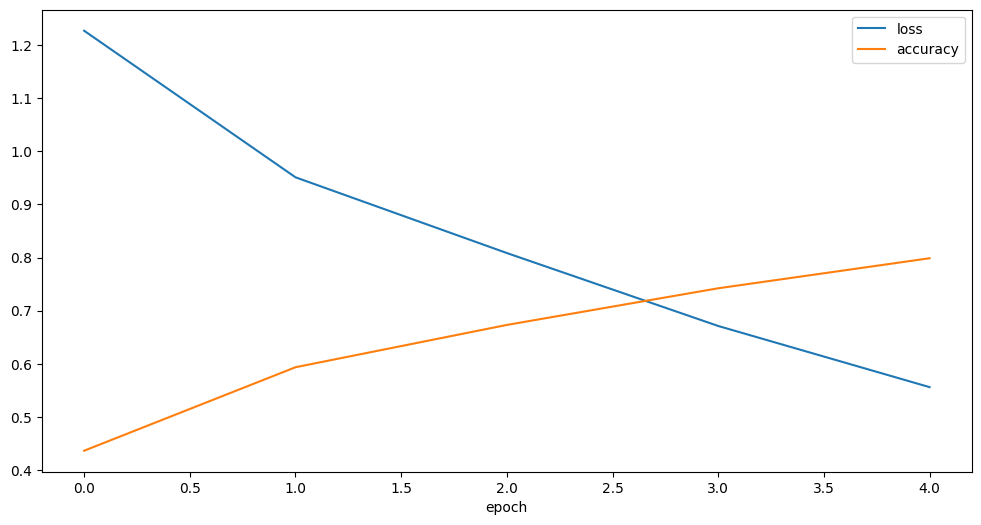

In [24]:
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(12, 6))  # Unpack axes from the tuple

history_df.plot(x="epoch", y=["loss", "accuracy"], ax=ax0)
# history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [25]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
benchmarks

125/125 [==============================] - 46s 349ms/step - loss: 0.3358 - accuracy: 0.9045


{'loss': 0.3358340859413147, 'accuracy': 0.9045000076293945}

In [26]:
import numpy as np

test_text = """Decent poke at an okay price. We got two bowls with sushi rice: salmon and albacore, and salmon and seared cajun tuna.Good: The salmon and tuna were good, and there's a large selection of  mixins and addons -- I consistently get the crab salad, seaweed salad, and tofu skins.
Bad: The albacore was overly salty and many of the pieces were overcooked and rubbery. The sauces are good but I wish there was more added, without having to pay extra."
Overall, nothing spectacular, but Pokeman is an average option in University City"""

test_input = tokernizer(test_text, padding="max_length", truncation=True, return_tensors="tf",max_length=500)

predictions = model.predict(dict(test_input))

# # Get the probabilities for each class
# logits = predictions.logits

# # Apply softmax to get probabilities
# probabilities = tf.nn.softmax(logits, axis=-1).numpy()# Convert logits to probabilities using softmax

print(predictions)

1/1 [==============================] - 2s 2s/step
[[0.00835222 0.20867357 0.7712796  0.00792805 0.00376658]]


In [27]:
predicted_label_index = np.argmax(predictions)
predicted_label_index

2

In [28]:
print("Ratings :" ,float(predicted_label_index + 1 ))

Ratings : 3.0


Saving and loading the model

In [34]:
# Save model architecture as JSON
model_json = model.to_json()
with open("Distilbert_TF_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("Distilbert_TF_weights.h5")

In [35]:
model.save('Distilbert_TF_.h5')

In [29]:
# model.save_pretrained('./model/clf')
# with open('./model/info.pkl', 'wb') as f:
#     pickle.dump((MODEL_NAME, MAX_LEN), f)

In [30]:
# new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
# model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

# clf = create_predictor(new_model, model_name, max_len)
# print(clf('this restaurant has horrible food'))

load model

In [31]:
# new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
# model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

# clf = create_predictor(new_model, model_name, max_len)
# print(clf('this restaurant has horrible food'))